In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
# Load dataset
train_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\train", transform=transform)
val_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\val", transform=transform)
test_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\test", transform=transform)

In [4]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

# Define EfficientNet model
model = models.resnet50(pretrained=True)

C:\Users\ankit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ankit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Display model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Define loss function with label smoothing
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [9]:
criterion = SmoothCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [10]:
# Training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [11]:
best_val_acc = 0.0
for epoch in range(45):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use tqdm for progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/45', ncols=100)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        pbar.set_postfix({'Train Loss': train_loss / (total_train / train_loader.batch_size), 'Train Acc': train_acc})
    
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct_val / total_val)

    print(f'Epoch [{epoch + 1}/45], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}')

    # Save model with best validation accuracy
    if val_acc_list[-1] > best_val_acc:
        best_val_acc = val_acc_list[-1]
        torch.save(model.state_dict(), 'resnet50_best_model.pth')

Epoch 1/45: 100%|█████████████| 1729/1729 [20:13<00:00,  1.43it/s, Train Loss=1.54, Train Acc=0.846]


Epoch [1/45], Train Loss: 1.5383, Train Acc: 0.8456, Val Loss: 1.4644, Val Acc: 0.8607


Epoch 2/45: 100%|█████████████| 1729/1729 [19:54<00:00,  1.45it/s, Train Loss=1.28, Train Acc=0.922]


Epoch [2/45], Train Loss: 1.2763, Train Acc: 0.9217, Val Loss: 1.4105, Val Acc: 0.8760


Epoch 3/45: 100%|█████████████| 1729/1729 [20:05<00:00,  1.43it/s, Train Loss=1.22, Train Acc=0.938]


Epoch [3/45], Train Loss: 1.2239, Train Acc: 0.9377, Val Loss: 1.3684, Val Acc: 0.8976


Epoch 4/45: 100%|█████████████| 1729/1729 [20:01<00:00,  1.44it/s, Train Loss=1.18, Train Acc=0.952]


Epoch [4/45], Train Loss: 1.1846, Train Acc: 0.9517, Val Loss: 1.4587, Val Acc: 0.8673


Epoch 5/45: 100%|█████████████| 1729/1729 [20:09<00:00,  1.43it/s, Train Loss=1.16, Train Acc=0.959]


Epoch [5/45], Train Loss: 1.1601, Train Acc: 0.9591, Val Loss: 1.3714, Val Acc: 0.8934


Epoch 6/45: 100%|█████████████| 1729/1729 [19:57<00:00,  1.44it/s, Train Loss=1.14, Train Acc=0.967]


Epoch [6/45], Train Loss: 1.1380, Train Acc: 0.9673, Val Loss: 1.4042, Val Acc: 0.8905


Epoch 7/45: 100%|█████████████| 1729/1729 [19:59<00:00,  1.44it/s, Train Loss=1.11, Train Acc=0.975]


Epoch [7/45], Train Loss: 1.1142, Train Acc: 0.9753, Val Loss: 1.4566, Val Acc: 0.8882


Epoch 8/45: 100%|██████████████| 1729/1729 [19:57<00:00,  1.44it/s, Train Loss=1.1, Train Acc=0.981]


Epoch [8/45], Train Loss: 1.0988, Train Acc: 0.9805, Val Loss: 1.4274, Val Acc: 0.8943


Epoch 9/45: 100%|█████████████| 1729/1729 [19:56<00:00,  1.45it/s, Train Loss=1.09, Train Acc=0.983]


Epoch [9/45], Train Loss: 1.0910, Train Acc: 0.9829, Val Loss: 1.4345, Val Acc: 0.8869


Epoch 10/45: 100%|████████████| 1729/1729 [19:53<00:00,  1.45it/s, Train Loss=1.08, Train Acc=0.988]


Epoch [10/45], Train Loss: 1.0763, Train Acc: 0.9878, Val Loss: 1.4649, Val Acc: 0.8916


Epoch 11/45: 100%|████████████| 1729/1729 [19:53<00:00,  1.45it/s, Train Loss=1.07, Train Acc=0.989]


Epoch [11/45], Train Loss: 1.0697, Train Acc: 0.9890, Val Loss: 1.4064, Val Acc: 0.9050


Epoch 12/45: 100%|████████████| 1729/1729 [20:00<00:00,  1.44it/s, Train Loss=1.07, Train Acc=0.991]


Epoch [12/45], Train Loss: 1.0673, Train Acc: 0.9905, Val Loss: 1.4209, Val Acc: 0.8982


Epoch 13/45: 100%|████████████| 1729/1729 [20:14<00:00,  1.42it/s, Train Loss=1.06, Train Acc=0.991]


Epoch [13/45], Train Loss: 1.0613, Train Acc: 0.9914, Val Loss: 1.3164, Val Acc: 0.9179


Epoch 14/45: 100%|████████████| 1729/1729 [20:57<00:00,  1.38it/s, Train Loss=1.06, Train Acc=0.992]


Epoch [14/45], Train Loss: 1.0585, Train Acc: 0.9923, Val Loss: 1.3889, Val Acc: 0.9063


Epoch 15/45: 100%|████████████| 1729/1729 [36:59<00:00,  1.28s/it, Train Loss=1.06, Train Acc=0.993]


Epoch [15/45], Train Loss: 1.0549, Train Acc: 0.9932, Val Loss: 1.4206, Val Acc: 0.9044


Epoch 16/45: 100%|████████████| 1729/1729 [21:31<00:00,  1.34it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [16/45], Train Loss: 1.0503, Train Acc: 0.9943, Val Loss: 1.3961, Val Acc: 0.9095


Epoch 17/45: 100%|████████████| 1729/1729 [21:05<00:00,  1.37it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [17/45], Train Loss: 1.0509, Train Acc: 0.9936, Val Loss: 1.3985, Val Acc: 0.9109


Epoch 18/45: 100%|████████████| 1729/1729 [20:52<00:00,  1.38it/s, Train Loss=1.05, Train Acc=0.995]


Epoch [18/45], Train Loss: 1.0469, Train Acc: 0.9950, Val Loss: 1.3886, Val Acc: 0.9117


Epoch 19/45: 100%|████████████| 1729/1729 [21:01<00:00,  1.37it/s, Train Loss=1.05, Train Acc=0.995]


Epoch [19/45], Train Loss: 1.0453, Train Acc: 0.9948, Val Loss: 1.4315, Val Acc: 0.9037


Epoch 20/45: 100%|████████████| 1729/1729 [21:00<00:00,  1.37it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [20/45], Train Loss: 1.0437, Train Acc: 0.9955, Val Loss: 1.3692, Val Acc: 0.9130


Epoch 21/45: 100%|████████████| 1729/1729 [20:56<00:00,  1.38it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [21/45], Train Loss: 1.0418, Train Acc: 0.9957, Val Loss: 1.3619, Val Acc: 0.9126


Epoch 22/45: 100%|████████████| 1729/1729 [21:19<00:00,  1.35it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [22/45], Train Loss: 1.0397, Train Acc: 0.9959, Val Loss: 1.3731, Val Acc: 0.9149


Epoch 23/45: 100%|████████████| 1729/1729 [21:08<00:00,  1.36it/s, Train Loss=1.04, Train Acc=0.995]


Epoch [23/45], Train Loss: 1.0421, Train Acc: 0.9954, Val Loss: 1.3818, Val Acc: 0.9029


Epoch 24/45: 100%|████████████| 1729/1729 [21:07<00:00,  1.36it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [24/45], Train Loss: 1.0408, Train Acc: 0.9956, Val Loss: 1.4186, Val Acc: 0.9082


Epoch 25/45: 100%|████████████| 1729/1729 [21:21<00:00,  1.35it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [25/45], Train Loss: 1.0371, Train Acc: 0.9962, Val Loss: 1.4020, Val Acc: 0.9124


Epoch 26/45: 100%|████████████| 1729/1729 [21:38<00:00,  1.33it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [26/45], Train Loss: 1.0359, Train Acc: 0.9963, Val Loss: 1.4163, Val Acc: 0.9124


Epoch 27/45: 100%|████████████| 1729/1729 [21:09<00:00,  1.36it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [27/45], Train Loss: 1.0373, Train Acc: 0.9964, Val Loss: 1.4188, Val Acc: 0.9111


Epoch 28/45: 100%|████████████| 1729/1729 [21:01<00:00,  1.37it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [28/45], Train Loss: 1.0326, Train Acc: 0.9973, Val Loss: 1.3953, Val Acc: 0.9184


Epoch 29/45: 100%|████████████| 1729/1729 [21:20<00:00,  1.35it/s, Train Loss=1.04, Train Acc=0.997]


Epoch [29/45], Train Loss: 1.0355, Train Acc: 0.9965, Val Loss: 1.3996, Val Acc: 0.9095


Epoch 30/45: 100%|████████████| 1729/1729 [21:16<00:00,  1.35it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [30/45], Train Loss: 1.0365, Train Acc: 0.9961, Val Loss: 1.4376, Val Acc: 0.9053


Epoch 31/45: 100%|████████████| 1729/1729 [21:32<00:00,  1.34it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [31/45], Train Loss: 1.0336, Train Acc: 0.9966, Val Loss: 1.3944, Val Acc: 0.9124


Epoch 32/45: 100%|████████████| 1729/1729 [21:14<00:00,  1.36it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [32/45], Train Loss: 1.0304, Train Acc: 0.9977, Val Loss: 1.4008, Val Acc: 0.9080


Epoch 33/45: 100%|████████████| 1729/1729 [21:16<00:00,  1.35it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [33/45], Train Loss: 1.0330, Train Acc: 0.9970, Val Loss: 1.4480, Val Acc: 0.9071


Epoch 34/45: 100%|████████████| 1729/1729 [21:15<00:00,  1.36it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [34/45], Train Loss: 1.0330, Train Acc: 0.9971, Val Loss: 1.4272, Val Acc: 0.9082


Epoch 35/45: 100%|████████████| 1729/1729 [21:31<00:00,  1.34it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [35/45], Train Loss: 1.0273, Train Acc: 0.9982, Val Loss: 1.4686, Val Acc: 0.8938


Epoch 36/45: 100%|████████████| 1729/1729 [24:56<00:00,  1.16it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [36/45], Train Loss: 1.0345, Train Acc: 0.9966, Val Loss: 1.4581, Val Acc: 0.9088


Epoch 37/45: 100%|████████████| 1729/1729 [26:03<00:00,  1.11it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [37/45], Train Loss: 1.0327, Train Acc: 0.9966, Val Loss: 1.4228, Val Acc: 0.9089


Epoch 38/45: 100%|████████████| 1729/1729 [21:39<00:00,  1.33it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [38/45], Train Loss: 1.0265, Train Acc: 0.9983, Val Loss: 1.4535, Val Acc: 0.9005


Epoch 39/45: 100%|████████████| 1729/1729 [21:41<00:00,  1.33it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [39/45], Train Loss: 1.0338, Train Acc: 0.9968, Val Loss: 1.5059, Val Acc: 0.8913


Epoch 40/45: 100%|████████████| 1729/1729 [21:29<00:00,  1.34it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [40/45], Train Loss: 1.0276, Train Acc: 0.9980, Val Loss: 1.4148, Val Acc: 0.9119


Epoch 41/45: 100%|████████████| 1729/1729 [20:59<00:00,  1.37it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [41/45], Train Loss: 1.0297, Train Acc: 0.9974, Val Loss: 1.4052, Val Acc: 0.9135


Epoch 42/45: 100%|████████████| 1729/1729 [21:15<00:00,  1.36it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [42/45], Train Loss: 1.0296, Train Acc: 0.9975, Val Loss: 1.4309, Val Acc: 0.9072


Epoch 43/45: 100%|████████████| 1729/1729 [21:15<00:00,  1.36it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [43/45], Train Loss: 1.0274, Train Acc: 0.9981, Val Loss: 1.4553, Val Acc: 0.8933


Epoch 44/45: 100%|████████████| 1729/1729 [20:53<00:00,  1.38it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [44/45], Train Loss: 1.0304, Train Acc: 0.9973, Val Loss: 1.3908, Val Acc: 0.9145


Epoch 45/45: 100%|████████████| 1729/1729 [21:08<00:00,  1.36it/s, Train Loss=1.02, Train Acc=0.999]


Epoch [45/45], Train Loss: 1.0244, Train Acc: 0.9987, Val Loss: 1.4614, Val Acc: 0.9038


In [12]:
print("train_loss_list = ",train_loss_list)
print("val_loss_list = ", val_loss_list)
print("train_acc_list = ",train_acc_list)
print("val_acc_list = ", val_acc_list)

train_loss_list =  [1.5383401383134656, 1.2763279728837065, 1.2239286394874922, 1.1845809129568248, 1.1600776079971022, 1.1379681905616288, 1.114159560051869, 1.098783799993847, 1.090987505907265, 1.076337557503638, 1.069703193949164, 1.067269801679824, 1.0613228286050385, 1.0585279244091415, 1.054883347831757, 1.0502580338782006, 1.0509019533701203, 1.0469271336214057, 1.0452827954995556, 1.043662414239141, 1.041809968206495, 1.039688906482081, 1.0420925584812948, 1.0407644167602785, 1.0371399938612056, 1.0359279664008172, 1.0372527883258287, 1.0326440292951893, 1.0354846356024006, 1.0365261364838096, 1.0335941920051552, 1.0304273894372327, 1.0329773604628527, 1.0329755979028308, 1.0272692335072524, 1.0344829488310805, 1.0326715315470743, 1.026504011151417, 1.0338246388680814, 1.0275715654333455, 1.0296818433020278, 1.0296250104628386, 1.0274054369118395, 1.0304403637378046, 1.0244185299181126]
val_loss_list =  [1.4643993396990695, 1.4104856911458468, 1.3683950222938166, 1.45874831599

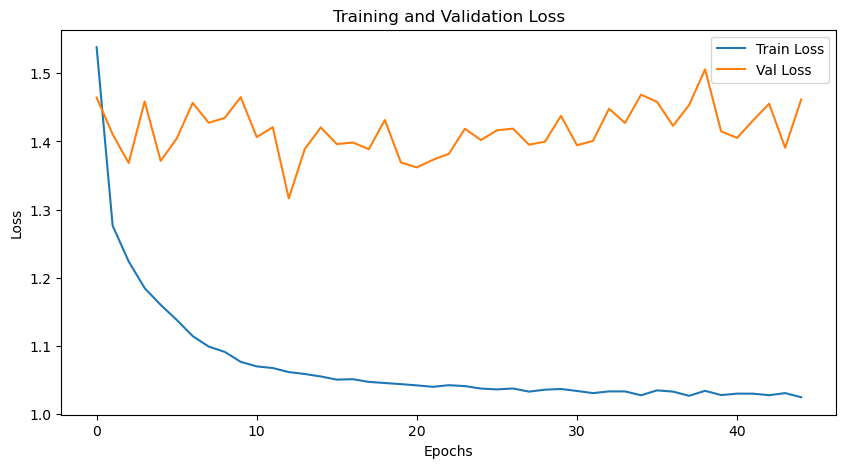

In [13]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

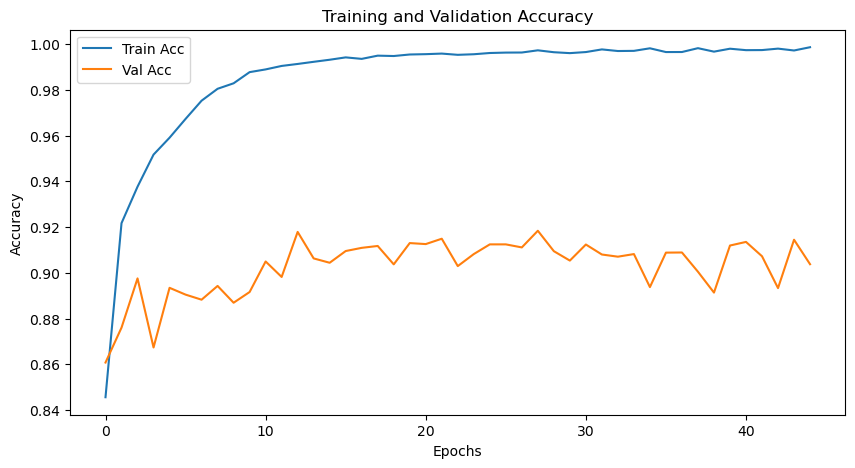

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
# Load best model
model.load_state_dict(torch.load('resnet50_best_model.pth'))

<All keys matched successfully>

In [16]:
# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Overall Accuracy: 0.9475
Precision: 0.9484
Recall: 0.9475
F1-score: 0.9457
